In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import pymc3 as pm
import theano
import theano.tensor as tt


logging.getLogger('pymc3').setLevel(logging.DEBUG)

import arviz
import IPython.display

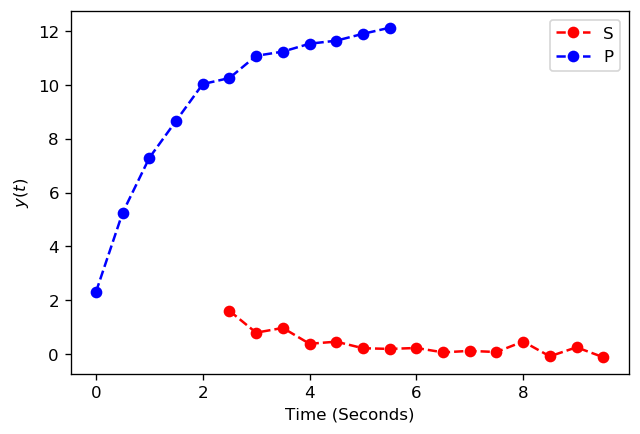

In [3]:
# For reproducibility
np.random.seed(19920908)

class Chem:
    @staticmethod
    def reaction(y, t, p):
        S, P = y[0], y[1]
        vmax, K_S = p[0], p[1]
        dPdt = vmax * (S / K_S + S)
        dSdt = -dPdt
        return [
            dSdt,
            dPdt,
        ]

# Times for observation
times = np.arange(0,10,0.5)
red = np.arange(5, len(times))
blue = np.arange(12)
x_obs_1 = times[red]
x_obs_2 = times[blue]

y0_true = (10, 2)
theta_true = vmax, K_S = (0.5, 2)
sigma = 0.2

y_obs = odeint(Chem.reaction, t=times, y0=y0_true, args=(theta_true,))
y_obs_1 = np.random.normal(y_obs[red,0], sigma)
y_obs_2 = np.random.normal(y_obs[blue,1], sigma)

fig, ax = plt.subplots(dpi=120)
plt.plot(x_obs_1, y_obs_1, label='S', linestyle='dashed', marker='o', color='red')
plt.plot(x_obs_2, y_obs_2, label='P', linestyle='dashed', marker='o', color='blue')
plt.legend()
plt.xlabel('Time (Seconds)')
plt.ylabel(r'$y(t)$')
plt.show()

In [4]:
theano.config.compute_test_value = 'raise'
theano.config.exception_verbosity = 'high'
theano.config.traceback.limit = 100

In [5]:
def get_model(new:bool):
    with pm.Model() as pmodel:    
        sigma = pm.HalfCauchy('sigma', 1)
        vmax = pm.Lognormal('vmax', 0, 1)
        K_S = pm.Lognormal('K_S', 0, 1)
        s0 = pm.Normal('red_0', mu=10, sd=2)

        if not new:
            print('Using old implementation')
            y_hat = pm.ode.DifferentialEquation(
                func=Chem.reaction,
                times=times,
                n_states=len(y0_true), n_odeparams=len(theta_true)
            )(
                y0=[s0, y0_true[1]],
                odeparams=[vmax, K_S]
            ).reshape((len(times),len(y0_true)))
        else:
            print('Using new implementation')
            y_hat = pm.ode.NewDifferentialEquation(
                func=Chem.reaction,
                times=times,
                n_states=len(y0_true), n_theta=len(theta_true)
            )(
                y0=[s0, y0_true[1]],
                theta=[vmax, K_S],
                return_sens=False
            )

        red_hat = y_hat.T[0][red]
        blue_hat = y_hat.T[1][blue]

        Y_red = pm.Normal('Y_red', mu=red_hat, sd=sigma, observed=y_obs_1)
        Y_blue = pm.Normal('Y_blue', mu=blue_hat, sd=sigma, observed=y_obs_2)

    return pmodel

def make_benchmark(new:bool):
    pmodel = get_model(new=new)
    
    # benchmark using the full gradient
    test_t = tt.grad(pmodel.logpt, [pmodel.sigma, pmodel.vmax, pmodel.K_S, pmodel.red_0])
    # compile a function to evaluate the gradient
    test_f = theano.function(inputs=pmodel.cont_vars, outputs=test_t)
    
    # test the compiled function with the true parameters
    print(f'Test gradient:')
    print(test_f(0.2, 0.5, 2, 10))
    
    # make a benchmarking function that uses random inputs (to avoid cheating via the cache)
    def bm():
        test_f(
            np.log(np.random.uniform(0.1, 0.2)),
            np.log(np.random.uniform(0.4, 0.6)),
            np.log(np.random.uniform(1.9, 2.1)),
            np.random.uniform(9, 11)
        )
    return pmodel, bm

In [14]:
m_old, bm_old = make_benchmark(new=False)

print('Performance:')
%timeit -n200 -r50 bm_old()

Applied log-transform to sigma and added transformed sigma_log__ to model.
Applied log-transform to vmax and added transformed vmax_log__ to model.
Applied log-transform to K_S and added transformed K_S_log__ to model.


Using old implementation


make_node for inputs -9101406265724462575
grad w.r.t. inputs -9101406265724462575


Test gradient:
[array(-1.45891956), array(-11.22516335), array(0.29856428), array(-8.51793668)]
Performance:
16.7 ms ± 519 µs per loop (mean ± std. dev. of 50 runs, 200 loops each)


In [16]:
m_new, bm_new = make_benchmark(new=True)

print('Performance:')
%timeit -n200 -r50 bm_new()

Applied log-transform to sigma and added transformed sigma_log__ to model.
Applied log-transform to vmax and added transformed vmax_log__ to model.
Applied log-transform to K_S and added transformed K_S_log__ to model.


Using new implementation


make_node for inputs 7311205408283958994
grad w.r.t. inputs 7311205408283958994


Test gradient:
[array(-1.45891956), array(-8.51793668), array(-9.55034683), array(-11.22516335)]
Performance:
16.9 ms ± 546 µs per loop (mean ± std. dev. of 50 runs, 200 loops each)


### Inspecting the computation graphs
The `ODEGradOp` is in the lower right corner. (upper graph)

In [17]:
theano.printing.pydotprint(tt.grad(m_old.logpt, m_old.vmax), 'old.png')
IPython.display.Image('old.png')

grad w.r.t. inputs -9101406265724462575


The output file is available at old.png


In [18]:
theano.printing.pydotprint(tt.grad(m_new.logpt, m_new.vmax), 'new.png')
IPython.display.Image('new.png')

grad w.r.t. inputs 7311205408283958994


The output file is available at new.png


In [20]:
from theano import d3viz
d3viz.d3viz(m_new.logpt, 'test.html')